In [2]:
try:
    import procgen_tools
except ImportError or ModuleNotFoundError:
    get_ipython().run_line_magic(magic_name='pip', line='install -U git+https://github.com/ulissemini/procgen-tools')

from procgen_tools.utils import setup

setup() # create directory structure and download data 

Already downloaded https://nerdsniper.net/mats/episode_data.tgz
Already downloaded https://nerdsniper.net/mats/patch_data.tgz
Already downloaded https://nerdsniper.net/mats/data.tgz
Already downloaded https://nerdsniper.net/mats/model_rand_region_5.pth


In [3]:
from procgen_tools.imports import *
from procgen_tools.procgen_imports import *

# Visualizing details of the goal misgeneralization nets
Let's understand lots of details about [the goal misgeneralization paper](https://arxiv.org/abs/2105.14111). In particular, we'll be looking at the cheese-maze task from the goal misgeneralization task, for which cheese was spawned in the 5x5 top-right corner of the maze. 

Key conclusions:
1. Convolutional layers limit speed of information propagation (_locality_). More precisely, ignoring the effect of `maxpool2D` layers, any portions of the state separated by `n` pixels take at least `ceil(n/2)` convolutional layers to interact.
2. In the maximal maze size of 64 x 64, there is at most **two** steps of computation involving information from e.g. opposite corners of the maze. 

Let's visualize the network structure. Here's a Mermaid diagram. 

![](https://i.imgur.com/5oSHoVQ.png) 

This network is actually substantially overparameterized. The convolutional layers have a `scale` setting, which is set to 4 in Langosco et al.'s trained networks. Scale and generalization seems similar across scale settings.

Let's examine how many parameters are in each layer, for the current network (which is `scale=4`). 

In [58]:
# Tabulate the number of model parameters per layer
from procgen_tools.visualization import format_label

from tabulate import tabulate
table = []
for name, param in policy.named_parameters():
    table.append([format_label(name), param.numel()])
total_params = sum([param.numel() for name, param in policy.named_parameters()])

# Display in a bar chart using plotly, setting the y axis to the label names

# Remove ".weight" from the labels 
non_bias_labels = [row[0] for row in table if 'bias' not in row[0]]
non_bias_labels = [label.replace('.weight', '') for label in non_bias_labels]
non_bias_table = [row for row in table if 'bias' not in row[0]]

fig = go.Figure(data=[go.Bar(y=non_bias_labels, x=[row[1] for row in non_bias_table], orientation='h')])
# Format the total number of parameters to be e.g. 365M
formatted_total = format(total_params, ',')
# Set subtitle to say total number of parameters
fig.update_layout(
    title={ 'text': f'Model Parameters per Layer', 'y':0.9, 'x':0.5, 'xanchor': 'center', 'yanchor': 'top'}, 
    xaxis_title='Parameters', 
    yaxis_title='Layer (excluding biases)',
    annotations=[ dict( x=0.45, y=1.12, xref='paper', yref='paper', text=f'{formatted_total} parameters in total', showarrow=False, font=dict( size=12)) ]
    )
# Set mouse-over text to show the number of parameters, without showing "Trace 0" etc.
fig.update_traces(text=[row[1] for row in non_bias_table], hovertemplate='%{text:,} parameters<extra></extra>', hoverlabel=dict(bgcolor='white'), )

# Set x axis to be logarithmic
fig.update_xaxes(type="log")

fig.show()

And here's a more dynamic view; small nodes are activations, and large nodes are `nn.Module`s.

In [35]:
hook.run_with_input(np.zeros((1,3, 64, 64), dtype=np.float32))
hook.get_graph(include_parent_modules=False)

:Graph   [start,end]

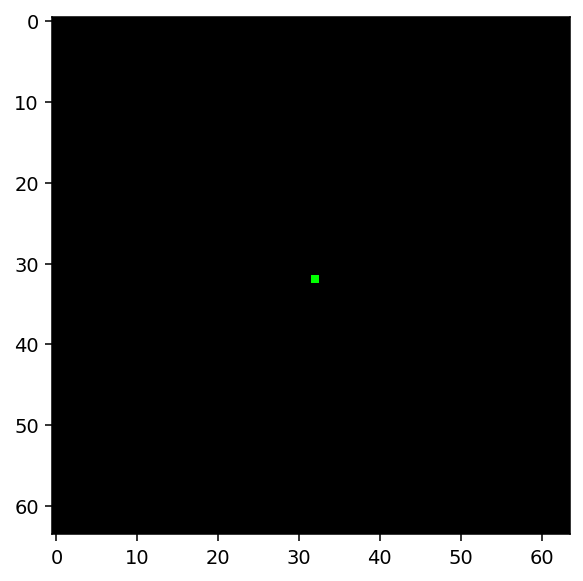

In [ ]:
def dummy_obs_pair(color: str, location: Tuple[int, int]=(32,32)):
    """ Returns a mostly-black image pair, the first of which contains a red/green/blue pixel in the center. Returns obs of shape (2, 3, 64, 64). """
    
    assert color in ['R', 'G', 'B'], f'Color must be one of R, G, B, not {color}'
    assert len(location) == 2, 'Location must be a tuple of length 2'
    assert all(0 <= col < 64 for col in location), 'Location must be in [0, 64)'

    channel = {'R': 0, 'G': 1, 'B': 2}[color]
    obs = np.zeros((2, 3, 64, 64), dtype=np.float32)
    obs[0, channel, location[0], location[1]] = 1 # Have one pixel in the middle, in the given channel
    return obs
    
# Let's load a dummy observation with only one nonzero value
plt.imshow(dummy_obs_pair("G")[0].transpose(1,2,0))

In [ ]:
# Get the available labels
hook.run_with_input(dummy_obs_pair('R'))
labels = list(hook.values_by_label.keys())[:-1] # Skip the "_out" layer and remove "embedder." prefixes
assert labels == list(map(expand_label, format_labels(labels)))

In [ ]:
# We can begin to see how information propagates across the net for a dummy single-pixel input
def activ_gen_px(col: int, row: int, layer_name: str, hook, color: str, pair: bool = False):
    """ Get the activations for running a forward pass on a dummy observation, in the given color. Returns shape of (batch, channels, rows, cols), where size batch=1 if pair=False, and batch=2 if pair=True. """
    return get_activations(dummy_obs_pair(color, (row, col)), hook, layer_name)

# Instantiate the plotter
activ_plotter = ActivationsPlotter(labels, plotter=lambda activations, fig: plot_activations(activations[0], fig=fig), activ_gen=activ_gen_px, hook=hook, coords_enabled=True, color="R") # TODO for some reason block2.maxpool_out has a different fig width?
activ_plotter.display()

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'],
                             [0.2, 'rgb(214,96,77)'], [0.3, 'rgb(244,165,130)'],
                             [0.4, 'rgb(253,219,199)'], [0.5, 'rgb(247,247,247)'],
                             [0.6, 'rgb(209,229,240)'], [0.7, 'rgb(146,197,222)'],
                             [0.8, 'rgb(67,147,195)'], [0.9, 'rgb(33,102,172)'],
                             [1.0, 'rgb(5,48,97)']],
              'type': 'heatmap',
              'uid': 'f5c504d2-4fbd-4449-96d2-4b10d29a48a0',
              'z': array([[0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          ...,
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
              'zmax': 1.0,
              '

In [ ]:
# Plot the diff between a single-pixel input and a blank input
activ_plotter = ActivationsPlotter(labels, plotter=lambda activations, fig: plot_activations(activations[0] - activations[1], fig=fig), activ_gen=activ_gen_px, hook=hook, coords_enabled=True, color="R")
activ_plotter.display()

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'],
                             [0.2, 'rgb(214,96,77)'], [0.3, 'rgb(244,165,130)'],
                             [0.4, 'rgb(253,219,199)'], [0.5, 'rgb(247,247,247)'],
                             [0.6, 'rgb(209,229,240)'], [0.7, 'rgb(146,197,222)'],
                             [0.8, 'rgb(67,147,195)'], [0.9, 'rgb(33,102,172)'],
                             [1.0, 'rgb(5,48,97)']],
              'type': 'heatmap',
              'uid': 'e1cd4143-c6a1-40cf-b5e1-3f4e1eec994c',
              'z': array([[0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          ...,
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
              'zmax': 1.0,
              '

In [ ]:
# Instantiate the plotter
nonzero_plotter = ActivationsPlotter(labels, plotter=plot_nonzero_diffs, activ_gen=activ_gen_px, hook=hook, coords_enabled=True, color="R", pair=True)
nonzero_plotter.display()

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'],
                             [0.2, 'rgb(214,96,77)'], [0.3, 'rgb(244,165,130)'],
                             [0.4, 'rgb(253,219,199)'], [0.5, 'rgb(247,247,247)'],
                             [0.6, 'rgb(209,229,240)'], [0.7, 'rgb(146,197,222)'],
                             [0.8, 'rgb(67,147,195)'], [0.9, 'rgb(33,102,172)'],
                             [1.0, 'rgb(5,48,97)']],
              'type': 'heatmap',
              'uid': '00fc0943-fee6-4aba-8a5e-6d44487a1a7d',
              'z': array([[0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          ...,
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.],
                          [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
              'zmax': 1.0,
              '

# 1: Locality
Consider `n` convolutional layers (3x3 kernel, stride=1, padding=1) which each preserve the height col width of the previous feature maps. The above demonstrates that after these layers, information can only propagate `n` L1 pixels. The network itself is composed of # TODO 

# Visualizing actual observation activations

In [ ]:
default_settings = {'channel_slider': 55, 'label_widget': 'block2.res1.resadd_out'}

In [ ]:
# Show a maze editor side-by-side with the interactive plotter
SEED = 5
venv = create_venv(num=1, start_level=SEED, num_levels=1) # This has to be a single maze, otherwise the vfield wont work
custom_maze_plotter = ActivationsPlotter(labels, lambda activations, fig: plot_activations(activations[0], fig=fig), values_from_venv, hook, defaults=default_settings, venv=venv)

widget_box = custom_vfield(policy, venv=venv, callback=custom_maze_plotter.update_plotter, ax_size = 2) 
# There are two copies of the vfield because 
display(widget_box)
    
custom_maze_plotter.display() 
# TODO make it so that it's easy to attach notes to files, load  

Box(children=(HBox(children=(GridspecLayout(children=(Button(layout=Layout(grid_area='widget001', height='0px'…

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(103,0,31)'], [0.1, 'rgb(178,24,43)'],
                             [0.2, 'rgb(214,96,77)'], [0.3, 'rgb(244,165,130)'],
                             [0.4, 'rgb(253,219,199)'], [0.5, 'rgb(247,247,247)'],
                             [0.6, 'rgb(209,229,240)'], [0.7, 'rgb(146,197,222)'],
                             [0.8, 'rgb(67,147,195)'], [0.9, 'rgb(33,102,172)'],
                             [1.0, 'rgb(5,48,97)']],
              'type': 'heatmap',
              'uid': '85acbcd3-dc79-47d4-9898-a32f5705fc5a',
              'z': array([[ 0.02779133, -0.02590676, -0.07078469, ..., -0.04562637, -0.02730033,
                           -0.01589137],
                          [-0.0011681 , -0.14533387, -0.16364552, ..., -0.12093185, -0.11846539,
                           -0.08173238],
                          [-0.066576  , -0.23137468, -0.15855052, ..., -0.24422255, -0.18919402,
                           -0.1876842 ],
                  

# Examine activations with attribution maps


[Integrated gradients](https://arxiv.org/abs/1802.03788) is an attribution method which works by approximating the following integral, where $F : \mathbb{R}^n \rightarrow \mathbb{R}$ is the network, $x$ is the input, $x'$ is the baseline, and $i$ is the feature.

$$
\mathrm{IntegratedGradients}_i(x) = (x_i - x_i') \times \int_{\alpha=0}^1 \frac{\partial F(x' + \alpha (x - x'))}{\partial x_i} d\alpha
$$

[Intuitively](https://www.tensorflow.org/tutorials/interpretability/integrated_gradients) we're accumulating all the change in output from changing $x'$ to $x$ along the linear path $\alpha x' + (1 - \alpha) x$. For a concrete example in words, let $x_i$ be the weight of a heavy exotic frog, $x_i'$ be the average weight over all frogs, $F(x)$ be the estimated jump height of a frog with all the features $x$ (one of which is weight). Given this, the equation above can be interpreted as

$$
\text{Weight gain of exotic frog} \times \text{Average rate jump height changes per unit weight gain} = \text{Jump height change of exotic frog \textbf{due to weight gain}}
$$

In other words, the integrated gradients vector is the vector of the change in output **due** to the change in each input feature.

As an implementation detail, we currently use $x' = \mathbf{0}$ as a baseline, though we'll be changing this soon.

For the interface, <span style="color:blue;">Blue</span> is the activation, brighter for positive, darker for negative. <span style="color:red;">Red</span> is the attribution, brighter for positive, darker for negative.


In [ ]:
from torch.distributions import Categorical
from captum.attr import IntegratedGradients

class WrappedModel(t.nn.Module):
    def __init__(self, hook: cmh.ModuleHook):
        super().__init__()
        assert isinstance(hook, cmh.ModuleHook), "Hook must be a ModuleHook"

        self.hook = hook

    def forward(self, labelled_activation: t.Tensor, obs: t.Tensor, label: str):
        assert isinstance(obs, t.Tensor) and obs.dtype == t.float32, "Obs must be a tensor of dtype float32"
        assert isinstance(labelled_activation, t.Tensor) and labelled_activation.dtype == t.float32, "Labelled activation must be a tensor of dtype float32"

        # could be faster cached but I'm not taking chances with hook reuse bugs
        mask = t.tensor(True) # mask all the things
        patches = {label: cmh.PatchDef(value=labelled_activation, mask=mask)}
        with self.hook.set_hook_should_get_custom_data(), self.hook.use_patches(patches):
            c, _ = self.hook.network(obs)

        # return probs
        return t.stack([c.probs[..., np.array(act_indexes)].sum(-1) for _, act_indexes in models.MAZE_ACTION_INDICES.items()], dim=-1)


model = WrappedModel(hook)
ig = IntegratedGradients(model)

In [ ]:
targets = {k: i for i, k in enumerate(models.MAZE_ACTION_INDICES.keys())}
venv = maze.create_venv(1,0,1)

def viz_attr(target: str, layer_name: str, alpha: float, std_clip_low: float, std_clip_high: float, channel: int = 0, update_counter: int = 0):
    obs = t.tensor(venv.reset(), dtype=t.float32, requires_grad=True)
    # TODO: Baseline/counterfactual for IG, defaults is zero and is not ideal.
    with hook.set_hook_should_get_custom_data():
        hook.network(obs)
        activ = hook.get_value_by_label(layer_name, convert=False)

    attr, delta = ig.attribute(activ, target=targets[target], return_convergence_delta=True, additional_forward_args=(obs, layer_name))
    attr = attr.detach().numpy()

    # Convert to numpy float image format; gaussian normalize to [0,1]
    activ_im = activ[0].detach().numpy()[channel]
    activ_im = (activ_im - activ_im.min()) / (activ_im.max() - activ_im.min())

    attr_im = attr[0][channel]

    # clip outliers
    mean, std = attr_im.mean(), attr_im.std()
    attr_im = np.clip(attr_im, mean - std_clip_low*std, mean + std_clip_high*std)
    # normalize for display
    attr_im = (attr_im - attr_im.min())
    if (attr_im.max() - attr_im.min()) != 0:
        attr_im /= (attr_im.max() - attr_im.min())
    else:
        print("WARNING: attribution failed, image is constant zeros. try a different channel?")

    # TODO: Maybe this should be log scale since model outputs probabilities? maybe model should output log probs?
    # hard to interpret.

    # alternative (non rgb) overlay
    # overlay_im = alpha * attr_im + (1-alpha) * activ_im
    # rb overlay
    green = np.zeros_like(attr_im)
    overlay_im = np.stack([alpha*attr_im, green, (1-alpha)*activ_im], axis=2)

    plt.imshow(overlay_im)


update_counter_widget = widgets.fixed(0) # CURSED

interact(
    viz_attr,
    target=widgets.Dropdown(options=list(targets.keys()), value='RIGHT', description='Target: '),
    layer_name=widgets.Dropdown(options=labels, value=labels[4], description='Label: '),
    alpha=widgets.FloatSlider(min=0, max=1, step=0.1, value=0.5),
    std_clip_low=widgets.FloatSlider(min=0, max=10, step=0.5, value=3), # NOTE: Feel free to make default settings better
    std_clip_high=widgets.FloatSlider(min=0, max=10, step=0.5, value=5),
    channel=widgets.IntSlider(min=0, max=128, step=1, value=0),
    update_counter=update_counter_widget,
);

widget_box = custom_vfield(policy, venv=venv, seed=SEED, callback=lambda _: update_counter_widget.set_trait('value', update_counter_widget.value + 1))
display(widget_box)


interactive(children=(Dropdown(description='Target: ', index=3, options=('LEFT', 'DOWN', 'UP', 'RIGHT', 'NOOP'…

Box(children=(HBox(children=(GridspecLayout(children=(Button(layout=Layout(grid_area='widget001', height='0px'…